# Mixture of Experts

Process of having multiple neural networks (experts) to solve a problem and then having a gating network to decide which expert to use for a given input.

## Mixture of Experts (MoE) vs Ensemble Learning
### Mixture of Experts (MoE):

In MoE, instead of having a single model making predictions, there are multiple "expert" models, each specializing in different aspects or subsets of the data.
These expert models are typically combined using a gating network, which determines how much weight each expert's prediction should be given for a particular input.
MoE is particularly useful when dealing with complex, heterogeneous data where different subsets or features may require different expertise to model effectively.
The gating network can learn to dynamically choose which expert to trust based on the input data, allowing the model to adapt its behavior to different contexts.

### Ensemble Learning:
General ensembling involves training multiple diverse models independently and then combining their predictions using some aggregation method (e.g., averaging, voting, stacking).
The idea behind ensembling is that by combining the predictions of multiple models, you can reduce the overall prediction error, as each model may capture different aspects of the data or make different types of errors.
Ensembling is a broad concept and can involve various techniques such as bagging, boosting, or stacking.
Unlike MoE, general ensembling does not involve explicitly partitioning the data or using specialized models for different subsets; instead, it relies on the diversity of independently trained models to improve overall performance.


References:
- [Mixture of Experts](https://en.wikipedia.org/wiki/Mixture_of_experts)
- [Mistral 7B](https://arxiv.org/abs/2310.06825)
- [Mixture of Experts in AI and Deep Learning](https://www.youtube.com/watch?v=3MX4RJbGIVQ&ab_channel=ComputingForAll)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Build Experts and Gating Network

In [2]:
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=1)

In [3]:
class Gating(nn.Module):
    def __init__(self, input_dim,
                 num_experts, dropout_rate=0.1):
        super(Gating, self).__init__()

        # Layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(128, 256)
        self.leaky_relu1 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(256, 128)
        self.leaky_relu2 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(128, num_experts)

    def forward(self, x):
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(self.leaky_relu1(self.fc2(x)))
        x = self.dropout3(self.leaky_relu2(self.fc3(x)))
        return torch.softmax(self.fc4(x), dim=1)

# Build Mixture of Experts Model

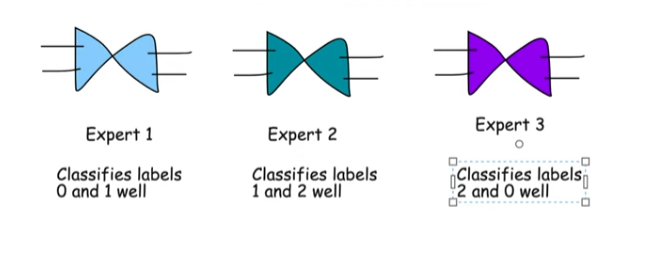

In [4]:
class MoE(nn.Module):
    def __init__(self, trained_experts):
        super(MoE, self).__init__()
        self.experts = nn.ModuleList(trained_experts)

        # Freezing the experts to ensure that they are not
        # learning when MoE is training.
        # Ideally, one can free them before sending the
        # experts to the MoE; in that case the following three
        # lines can be commented out.
        for expert in self.experts:
            for param in expert.parameters():
                param.requires_grad = False

        num_experts = len(trained_experts)
        # Assuming all experts have the same input dimension
        input_dim = trained_experts[0].fc1.in_features
        self.gating = Gating(input_dim, num_experts)

    def forward(self, x):
        # Get the weights from the gating network
        weights = self.gating(x)

        # Calculate the expert outputs
        outputs = torch.stack(
            [expert(x) for expert in self.experts], dim=2)

        # Adjust the weights tensor shape to match the expert outputs
        weights = weights.unsqueeze(1).expand_as(outputs)

        # Multiply the expert outputs with the weights and
        # sum along the third dimension
        return torch.sum(outputs * weights, dim=2)

# Generating MoE Data

In [ ]:
# Generate the dataset
num_samples = 5000
input_dim = 4
hidden_dim = 32

In [ ]:
# Generate equal numbers of labels 0, 1, and 2
y_data = torch.cat([
    torch.zeros(num_samples // 3),
    torch.ones(num_samples // 3),
    torch.full((num_samples - 2 * (num_samples // 3),), 2)  # Filling the remaining to ensure exact num_samples
]).long()

# Biasing the data based on the labels
x_data = torch.randn(num_samples, input_dim)

In [ ]:
for i in range(num_samples):
    if y_data[i] == 0:
        x_data[i, 0] += 1  # Making x[0] more positive
    elif y_data[i] == 1:
        x_data[i, 1] -= 1  # Making x[1] more negative
    elif y_data[i] == 2:
        x_data[i, 0] -= 1  # Making x[0] more negative

# Shuffle the data to randomize the order
indices = torch.randperm(num_samples)
x_data = x_data[indices]
y_data = y_data[indices]

# Verify the label distribution
y_data.bincount()

In [ ]:
# Shuffle the data to ensure x_data and y_data remain aligned
shuffled_indices = torch.randperm(num_samples)
x_data = x_data[shuffled_indices]
y_data = y_data[shuffled_indices]

In [ ]:
# Splitting data for training individual experts
# Use the first half samples for training individual experts
x_train_experts = x_data[:int(num_samples/2)]
y_train_experts = y_data[:int(num_samples/2)]

mask_expert1 = (y_train_experts == 0) | (y_train_experts == 1)
mask_expert2 = (y_train_experts == 1) | (y_train_experts == 2)
mask_expert3 = (y_train_experts == 0) | (y_train_experts == 2)

In [ ]:
# Select an almost equal number of samples for each expert
num_samples_per_expert = \
min(mask_expert1.sum(), mask_expert2.sum(), mask_expert3.sum())

x_expert1 = x_train_experts[mask_expert1][:num_samples_per_expert]
y_expert1 = y_train_experts[mask_expert1][:num_samples_per_expert]

x_expert2 = x_train_experts[mask_expert2][:num_samples_per_expert]
y_expert2 = y_train_experts[mask_expert2][:num_samples_per_expert]

x_expert3 = x_train_experts[mask_expert3][:num_samples_per_expert]
y_expert3 = y_train_experts[mask_expert3][:num_samples_per_expert]

In [5]:
# Splitting the next half samples for training MoE model and for testing
x_remaining = x_data[int(num_samples/2)+1:]
y_remaining = y_data[int(num_samples/2)+1:]

split = int(0.8 * len(x_remaining))
x_train_moe = x_remaining[:split]
y_train_moe = y_remaining[:split]

x_test = x_remaining[split:]
y_test = y_remaining[split:]

print(x_train_moe.shape,"\n", x_test.shape,"\n",
      x_expert1.shape,"\n",
      x_expert2.shape,"\n", x_expert3.shape)

torch.Size([1999, 4]) 
 torch.Size([500, 4]) 
 torch.Size([1656, 4]) 
 torch.Size([1656, 4]) 
 torch.Size([1656, 4])


# Training Individual Experts

In [6]:
# Define hidden dimension
output_dim = 3
hidden_dim = 32

epochs = 500
learning_rate = 0.001


# Instantiate the experts
expert1 = Expert(input_dim, hidden_dim, output_dim)
expert2 = Expert(input_dim, hidden_dim, output_dim)
expert3 = Expert(input_dim, hidden_dim, output_dim)

# Set up loss
criterion = nn.CrossEntropyLoss()

# Optimizers for experts
optimizer_expert1 = optim.Adam(expert1.parameters(), lr=learning_rate)
optimizer_expert2 = optim.Adam(expert2.parameters(), lr=learning_rate)
optimizer_expert3 = optim.Adam(expert3.parameters(), lr=learning_rate)

# Training loop for expert 1
for epoch in range(epochs):
    optimizer_expert1.zero_grad()
    outputs_expert1 = expert1(x_expert1)
    loss_expert1 = criterion(outputs_expert1, y_expert1)
    loss_expert1.backward()
    optimizer_expert1.step()

# Training loop for expert 2
for epoch in range(epochs):
    optimizer_expert2.zero_grad()
    outputs_expert2 = expert2(x_expert2)
    loss_expert2 = criterion(outputs_expert2, y_expert2)
    loss_expert2.backward()
    optimizer_expert2.step()

# Training loop for expert 3
for epoch in range(epochs):
    optimizer_expert3.zero_grad()
    outputs_expert3 = expert3(x_expert3)
    loss_expert3 = criterion(outputs_expert3, y_expert3)
    loss_expert3.backward()

/home/saul/.pyenv/versions/3.11.8/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train Mixture of Experts Model

In [7]:
# Create the MoE model with the trained experts
moe_model = MoE([expert1, expert2, expert3])

# Train the MoE model
optimizer_moe = optim.Adam(moe_model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    optimizer_moe.zero_grad()
    outputs_moe = moe_model(x_train_moe)
    loss_moe = criterion(outputs_moe, y_train_moe)
    loss_moe.backward()
    optimizer_moe.step()

In [8]:
# Evaluate all models
def evaluate(model, x, y):
    with torch.no_grad():
        outputs = model(x)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / len(y)
    return accuracy

In [9]:
accuracy_expert1 = evaluate(expert1, x_test, y_test)
accuracy_expert2 = evaluate(expert2, x_test, y_test)
accuracy_expert3 = evaluate(expert3, x_test, y_test)
accuracy_moe = evaluate(moe_model, x_test, y_test)

print("Expert 1 Accuracy:", accuracy_expert1)
print("Expert 2 Accuracy:", accuracy_expert2)
print("Expert 3 Accuracy:", accuracy_expert3)
print("Mixture of Experts Accuracy:", accuracy_moe)

Expert 1 Accuracy: 0.502
Expert 2 Accuracy: 0.5
Expert 3 Accuracy: 0.204
Mixture of Experts Accuracy: 0.634
